In [1]:
import time

import torch
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score

import numpy as np
import PIL
import random
from IPython.core.display import Image, display

import matplotlib.pyplot as plt

In [2]:
#отключает warnings pytorch
import warnings
warnings.filterwarnings('ignore')

In [3]:
DEVICE_ID = 0
DEVICE = torch.device('cuda:%d' % DEVICE_ID)
torch.cuda.set_device(DEVICE_ID)

### Для запуска без GPU раскомментировать и закоментировать код выше
# DEVICE = torch.device('cpu')

In [4]:
np.random.seed(100500)

def data2image(data):
    res = np.transpose(np.reshape(data ,(3, 32,32)), (1,2,0))
    return PIL.Image.fromarray(np.uint8(res))

def imshow(img):
    if isinstance(img, torch.Tensor): img = img.numpy().astype('uint8')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
def prediction2classes(output_var):
    _, predicted = torch.max(output_var.data, 1)
    predicted.squeeze_()
    classes = predicted.tolist()
    return classes

def make_solution_pytorch(net, input_tensor, a_batch_size):
    res = []
    net = net.eval()
    cur_pos = 0
    while cur_pos <= len(input_tensor):
        outputs = net(input_tensor[cur_pos:cur_pos+a_batch_size])
        res += prediction2classes(outputs)
        cur_pos += a_batch_size
    return res

def plot_images(images, cls_pred=None):
    fig, axes = plt.subplots(3, 3)

    for i, ax in enumerate(axes.flat):
        # plot img
        ax.imshow(images[i, :, :, :], interpolation='spline16')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

In [5]:
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, utils
from PIL import Image

class CifarDataset(Dataset):
    def __init__(self, input_path, is_train=True, transform=None):
                        
        data = np.load(input_path)
        if is_train: 
            self.Y, self.X = np.hsplit(data, [1]) 
            self.Y = [item[0] for item in self.Y]
        else: 
            self.X = data
            self.Y = None
            
        self.X = self.X.reshape((self.X.shape[0], 3, 32, 32))
        self.X = self.X.transpose((0, 2, 3, 1)) #приводим к виду (N, H, W, C)
        self.X = [Image.fromarray(img) for img in self.X]
                
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        sample = self.X[idx]

        if self.transform: sample = self.transform(sample)

        if self.Y is None: return sample
        else: return (sample, self.Y[idx])

In [6]:
#тут папки с проблема должны быть заключены в ""
PATH_OF_DATA= 'data/'
!ls {PATH_OF_DATA}

homework_4_no_classes.test.npy	my_solution.csv
homework_4.train.npy		my_solution_lenet.csv


In [7]:
#Тут папки с пробелами НЕ надо заключать в ""
DATA_PATH  = 'data/'
train_path = 'homework_4.train.npy'
test_path  = 'homework_4_no_classes.test.npy'

In [8]:
np_mean = np.mean([item[0].numpy() for item in CifarDataset(DATA_PATH + train_path, transform=transforms.ToTensor())], axis=(0,2,3))
np_std = np.std([item[0].numpy() for item in CifarDataset(DATA_PATH + train_path, transform=transforms.ToTensor())], axis=(0,2,3))

In [9]:
np_mean, np_mean.shape

(array([0.50760865, 0.48708203, 0.44149536], dtype=float32), (3,))

In [10]:
np_std, np_std.shape

(array([0.26764476, 0.2567687 , 0.27647924], dtype=float32), (3,))

In [11]:
cifar_transform_norm = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

cifar_test_transform_norm = transforms.Compose([    
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

In [12]:
def get_train_valid_loader(data_dir,
                           batch_size,
                           valid_size=0.1,
                           shuffle=True,
                           show_sample=True,
                           num_workers=4,
                           pin_memory=False):
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    # load the dataset
    train_dataset = CifarDataset(
        input_path=data_dir, is_train=True, transform=cifar_transform_norm,
    )

    valid_dataset = CifarDataset(
        input_path=data_dir, is_train=True, transform=cifar_test_transform_norm,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


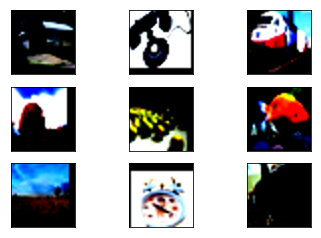

In [13]:
train_loader, valid_loader = get_train_valid_loader(DATA_PATH + train_path, batch_size=128)

In [14]:
dataset_test_norm = CifarDataset(DATA_PATH + test_path, is_train=False, transform=cifar_test_transform_norm)
dataloader_test_norm = DataLoader(dataset_test_norm, batch_size=128, shuffle=False, num_workers=1)

In [15]:
def train_network(a_net, 
                  a_device,
                  a_epochs=164,
                  a_batch_size=128,
                  a_lr=0.1):
    
    start_time = time.time()
    train_acc, valid_acc = [], []
    net = a_net.to(a_device)

    criterion = nn.CrossEntropyLoss()
    optimizer = None#torch.optim.SGD(a_net.parameters(), lr=a_lr, weight_decay=0.0001, momentum=0.9)

    prev_epoch_time = start_time
    for epoch in range(a_epochs):  # loop over the dataset multiple times
        if epoch == 0:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/10, weight_decay=0.0001, momentum=0.9)
        elif epoch == 1:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr, weight_decay=0.0001, momentum=0.9)
        elif epoch == 82:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/10, weight_decay=0.0001, momentum=0.9) 
        elif epoch == 123:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/100, weight_decay=0.0001, momentum=0.9) 
        
        net = net.train()        
        epoch_accuracy = 0.0
        epoch_iters = 0
        for item in train_loader:
            
            epoch_iters += 1

            inputs = item[0].to(a_device)
            labels = item[1].long().to(a_device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_accuracy += accuracy_score(labels.cpu(), prediction2classes(outputs))

        epoch_accuracy /= epoch_iters
        train_acc.append(epoch_accuracy)
        
        net.eval()
        epoch_accuracy = 0.0
        epoch_iters = 0
        for item in valid_loader:
            
            epoch_iters += 1

            inputs = item[0].to(a_device)
            labels = item[1].long().to(a_device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            epoch_accuracy += accuracy_score(labels.cpu(), prediction2classes(outputs))

        epoch_accuracy /= epoch_iters
        valid_acc.append(epoch_accuracy)
        
        
        
        print("Epoch ", epoch, ' | Train acc: ', round(train_acc[-1], 4), ' | Valid acc: ', round(valid_acc[-1], 4))
        cur_epoch_time = time.time()
        print('Epoch time : ', cur_epoch_time - prev_epoch_time )
        prev_epoch_time = cur_epoch_time

    print('Finished Training')
    print("Total time : ", (time.time()-start_time))
    
    plt.plot(train_acc, label='Train')
    plt.plot(valid_acc, label='Validation')
    plt.legend()
#     plt.grid()
    plt.grid(c='grey')

In [16]:
DOWNSAMPLE_COEF = 2

def conv3x3(a_in_planes, a_out_planes, a_stride=1):
    """
    Основной строительный блок конволюций для ResNet
    Включает в себя padding=1 - чтобы размерность сохранялась после его применения
    """
    return nn.Conv2d(a_in_planes, a_out_planes,  stride=a_stride,
                     kernel_size=3, padding=1, bias=False)

def x_downsample(a_in_channels):
     return nn.Conv2d(a_in_channels, 
               a_in_channels*DOWNSAMPLE_COEF,
               kernel_size=1,
               stride=2,
               bias=False)

In [17]:
class CifarResidualBlock(nn.Module):
    def __init__(self, a_in_channels, make_downsample=False, use_skip_connection=True, is_first=False):
        super(CifarResidualBlock, self).__init__()
        self.use_skip_connection = use_skip_connection
        self.make_downsample = make_downsample
        coef = DOWNSAMPLE_COEF if make_downsample else 1
        
        if make_downsample and use_skip_connection:
            self.downsample = x_downsample(a_in_channels)

        self.batchnorm1 = nn.BatchNorm2d(a_in_channels)
        self.relu1 = nn.ReLU()
        self.conv1 = conv3x3(a_in_channels, a_in_channels*coef, a_stride=coef)
        self.dropout = nn.Dropout(p=.3)
        self.batchnorm2 = nn.BatchNorm2d(a_in_channels*coef)
        self.relu2 = nn.ReLU()
        self.conv2 = conv3x3(a_in_channels*coef, a_in_channels*coef)
            
    def forward(self, x):
        identity = self.relu1(self.batchnorm1(x))
        if self.make_downsample and self.use_skip_connection:
            identity = self.downsample(x)  
        
        out = self.batchnorm1(x)
        out = self.relu1(out)    
        out = self.conv1(out)
        out = self.dropout(out)
        out = self.batchnorm2(out)
        out = self.relu2(out)
        out = self.conv2(out)
        
        
        if self.use_skip_connection:
            out += identity
            
        return out

In [18]:
class CifarResNet(nn.Module):
    
    def __init__(self, n=4, k=2):
        super(CifarResNet, self).__init__()
        
        
        self.features = nn.Sequential()
        
        self.features.add_module('conv3x3', conv3x3(3, 16*k))
        for i in range(n):
            self.features.add_module(f'res_block_1_{i}', CifarResidualBlock(16*k))

        self.features.add_module(f'res_block_2_0', CifarResidualBlock(16*k, make_downsample=True))

        for i in range(n-1):
            self.features.add_module(f'res_block_2_{i+1}', CifarResidualBlock(32*k))

        self.features.add_module(f'res_block_3_0', CifarResidualBlock(32*k, make_downsample=True))
        for i in range(n-1):
            self.features.add_module(f'res_block_3_{i+1}', CifarResidualBlock(64*k))
            
        self.global_avg_pooling = nn.AvgPool2d(kernel_size=8)
        self.fc_classifier = nn.Linear(64*k, 100)
        
    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pooling(x)        
        x = x.view((x.size()[0], -1))        
        x = self.fc_classifier(x)        
        return x

Epoch  0  | Train acc:  0.0465  | Valid acc:  0.0668
Epoch time :  24.197877883911133
Epoch  1  | Train acc:  0.0903  | Valid acc:  0.1125
Epoch time :  18.364163637161255
Epoch  2  | Train acc:  0.1745  | Valid acc:  0.15
Epoch time :  18.139216661453247
Epoch  3  | Train acc:  0.2567  | Valid acc:  0.2461
Epoch time :  17.579416513442993
Epoch  4  | Train acc:  0.3283  | Valid acc:  0.2795
Epoch time :  18.034003973007202
Epoch  5  | Train acc:  0.3828  | Valid acc:  0.3297
Epoch time :  18.36010193824768
Epoch  6  | Train acc:  0.4267  | Valid acc:  0.3535
Epoch time :  18.326202630996704
Epoch  7  | Train acc:  0.4648  | Valid acc:  0.4307
Epoch time :  17.7482852935791
Epoch  8  | Train acc:  0.4914  | Valid acc:  0.4121
Epoch time :  17.596043825149536
Epoch  9  | Train acc:  0.5181  | Valid acc:  0.4924
Epoch time :  17.770968437194824
Epoch  10  | Train acc:  0.5332  | Valid acc:  0.4914
Epoch time :  18.19763731956482
Epoch  11  | Train acc:  0.5522  | Valid acc:  0.4869
Epoch

Epoch  95  | Train acc:  0.9052  | Valid acc:  0.7037
Epoch time :  14.704638004302979
Epoch  96  | Train acc:  0.9061  | Valid acc:  0.7014
Epoch time :  18.19565176963806
Epoch  97  | Train acc:  0.9092  | Valid acc:  0.7068
Epoch time :  14.410128355026245
Epoch  98  | Train acc:  0.9081  | Valid acc:  0.6971
Epoch time :  17.88682746887207
Epoch  99  | Train acc:  0.9115  | Valid acc:  0.6941
Epoch time :  12.937650203704834
Epoch  100  | Train acc:  0.9123  | Valid acc:  0.6908
Epoch time :  18.760639667510986
Epoch  101  | Train acc:  0.914  | Valid acc:  0.6979
Epoch time :  13.736581325531006
Epoch  102  | Train acc:  0.9144  | Valid acc:  0.6951
Epoch time :  18.711477756500244
Epoch  103  | Train acc:  0.9177  | Valid acc:  0.6977
Epoch time :  16.79881739616394
Epoch  104  | Train acc:  0.9203  | Valid acc:  0.6975
Epoch time :  17.50234293937683
Epoch  105  | Train acc:  0.9198  | Valid acc:  0.6963
Epoch time :  15.187850713729858
Epoch  106  | Train acc:  0.92  | Valid ac

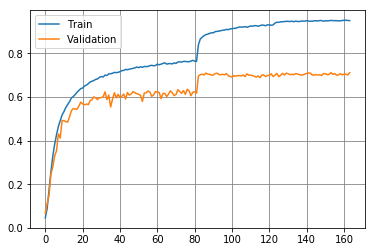

In [19]:
resnet = CifarResNet()
train_network(resnet, torch.device(DEVICE))

# Важно переключить сеть в режим eval - иначе dropout будет работать некорректно

In [20]:
def make_solution(a_net, a_device):
    res = []
    net = a_net.eval()
    for item in dataloader_test_norm:
        inputs = item.to(a_device)
        outputs = net(inputs) 

        res += prediction2classes(outputs)
    return res

In [21]:
# my_solution = make_solution(dense_net, DEVICE)
my_solution = make_solution(resnet, DEVICE)

In [22]:
file_name = DATA_PATH + 'my_solution.csv'

with open(file_name, 'w') as fout:
    print('Id', 'Prediction', sep=',', file=fout)
    for i, prediction in enumerate(my_solution):
        print(i, prediction, sep=',', file=fout)
        
# from google.colab import files
# files.download(file_name)